# Example for NCI users: Regional Tasmania JRA-55 and ACCESS-OM2

**Before you begin, make sure you have access to the relevent projects to access the data listed below**

## What does this notebook do?
This notebook is designed to set you up with a working MOM6 regional configuration. First, try and get it running with our default Tasmania case, then you can clone the notebook and modify for your region of interest. 

Input Type | Source | Location on NCI
---|---|---
Surface | [JRA55 surface forcing](https://climatedataguide.ucar.edu/climate-data/jra-55) | `/g/data/ik11`
Ocean | [ACCESS-OM2-01](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/description) |  `/g/data/ik11`  
Bathymetry | [GEBCO](https://www.gebco.net/data_and_products/gridded_bathymetry_data/) | `/g/data/ik11`

Additionally, you'll need access to `/g/data/x77/` if you want to use the same executable using the latest FMS build (a good idea for troubleshooting).

In [1]:
## To simply use Ashley's version of this package, uncomment the following:
import os
# os.chdir("/home/149/ab8992/cosima_regional/regional-mom6/")
#IMPORTANT: As of Nov 2023 you need to use analysis-unstable to get the latest version of xESMF or bathymetry regridding won't work
import xarray as xr
import regional_mom6 as rm
from pathlib import Path
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41687/status,
Dashboard: /proxy/41687/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43307,Workers: 4
Dashboard: /proxy/41687/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:45487,Total threads: 4
Dashboard: /proxy/42799/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:33009,


## What does this package do?

Setting up a regional model in MOM6 can be a pain. The goal of this package is that users should spend their debugging time fixing a model that's running and doing weird things, rather than puzzling over a model that won't even start.

In running this notebook, you'll hopefully have a running MOM6 regional model. There will still be a lot of fiddling to do with the MOM_input file to make sure that the parameters are set up right for your domain, and you might want to manually edit some of the input files. BUT, this package should help you bypass most of the woes of regridding, encoding and understanding the arcane arts of the MOM6 boundary segment files. 


## What does this notebook do?

This notebook demonstrates how to set up a regional domain using the package. By the end you should have a running MOM6 experiment on the domain of your choice. To make a stable test case:

* Avoid any regions with ice
* Avoid regions near the north pole
* Although the default configuration is meant to be RYF, I've not fixed up the calendar and encoding to run longer than a year just yet


Input Type | Source
---|---
Surface | JRA 
Ocean | ACCESS OM2-01
Bathymetry | Gebco

## Step 0: Your personal environment variables

In [2]:
scratch = "/scratch/v45/ab8992"
home = "/home/149/ab8992"

## Step 1: Choose our domain, define workspace paths

To make sure that things are working I'd recommend starting with the default example defined below. If this runs ok, then change to a domain of your choice and hopefully it runs ok too! There's some troubleshooting you can do if not (check readme / readthedocs)

To find the lat/lon of the domain you want to test you can use <a href="https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/download" > this GUI </a> and copy paste below

In [12]:
expt_name = "tasmania-example"

## Choose your coordinates and the name of your experiment
yextent = [-48,-38.95] ## latitude
xextent = [143,150] ## longitude

daterange = ["1990-01-01 00:00:00", "1990-01-05 00:00:00"] ## 2003 is a good compromise for GLORYs and JRA forcing as they overlap. JRA ends in 2012, GLORYS starts in 1993

## Place where all your input files go
inputdir = f"{scratch}/regional_mom6_configs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = f"{home}/mom6_rundirs/{expt_name}/"

## Directory where fre tools are stored
toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables

## Directory where ocean model cut-outs go before processing
tmpdir = f"{scratch}/regional_tmp/{expt_name}"

for i in [rundir,tmpdir,inputdir]:
    if not os.path.exists(i):
        os.makedirs(str(i))



## Step 2: Prepare ocean forcing data

We need to cut out our ocean forcing. The pipeline expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is "east_unprocessed" and "ic_unprocessed" for initial condition. The following provides an example for cutting out the necessary forcing files from an ocean model. It's hardcoded to pull data from a Repeat Year Forced ACCESS-OM2-01 database, but you should be able to recycle parts of the code to cut out data from a dataset of your choice


**NOTE: this is hardcoded for the year of 1990, which corresponds to files 1077 - 1082. If you want to modify, you'll need to choose the right path to the year of your choice, or use the COSIMA cookbook to locate your data files**

In [6]:


## Cut out 3 months of forcing from 1990
om2_input = xr.open_mfdataset(f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1077/ocean/ocean_daily*",parallel=True,chunks='auto')[["u","v","salt","temp","eta_t"]].sel(    
    yu_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2),
    yt_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2)
).isel(time = slice(0,5))


# Cut out initial condition and save
ic = om2_input.isel(time = 0)

## Nicer Slicer handles seams in longitude and different grids. Ensures that the output matches our 'xextent'
ic = rm.nicer_slicer(ic,[xextent[0],xextent[1]],["xu_ocean","xt_ocean"])
ic.to_netcdf(tmpdir + "/ic_unprocessed")

## Cut out East and West segments. Does lat slice first then uses nicer slicer for lon slice
eastwest = om2_input.sel(    
    yu_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2),
    yt_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2)
)
rm.nicer_slicer(eastwest,[xextent[1],xextent[1]],["xu_ocean","xt_ocean"]).to_netcdf(tmpdir + "/east_unprocessed")
rm.nicer_slicer(eastwest,[xextent[0],xextent[0]],["xu_ocean","xt_ocean"]).to_netcdf(tmpdir + "/west_unprocessed")

## Cut out North and South segments
northsouth = rm.nicer_slicer(om2_input,[xextent[0],xextent[1]],["xu_ocean","xt_ocean"])
northsouth.sel(
    yu_ocean = slice(yextent[1] - 0.2,yextent[1] + 0.2),
    yt_ocean = slice(yextent[1] - 0.2,yextent[1] + 0.2)
).to_netcdf(tmpdir + "/north_unprocessed")
northsouth.sel(
    yu_ocean = slice(yextent[0] - 0.2,yextent[0] + 0.2),
    yt_ocean = slice(yextent[0] - 0.2,yextent[0] + 0.2)
).to_netcdf(tmpdir + "/south_unprocessed")

## Step 3: Make experiment object
This object keeps track of your domain basics, as well as generating the hgrid, vgrid and setting up the folder structures. 




In [15]:
expt = rm.experiment(
    xextent,
    yextent,
    daterange,
    0.05,  # Horizontal Resolution
    75,    # Number of vertical layers
    10,    # Ratio of largest to smallest vertical layer. Select 1 for linear, negative number for higher resolution at bottom
    4500,  # Depth of simulation
    rundir,
    inputdir,
    toolpath
)

NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
FRE TOOLS: Make solo mosaic


CompletedProcess(args=['/home/157/ahg157/repos/mom5/src/tools/make_solo_mosaic/make_solo_mosaic', '--num_tiles', '1', '--dir', '.', '--mosaic_name', 'ocean_mosaic', '--tile_file', 'hgrid.nc'], returncode=0)


After running you can have a look at your grids by calling `expt.hgrid` and `expt.vgrid`

Plotting vgrid with marker = '.' option lets you see the spacing, or plotting 
```python
np.diff(expt.vgrid.zl).plot(marker = '.')
```
 shows you the vertical spacing profile.

 ### Modular workflow!

After constructing your expt object, if you don't like the default hgrid and vgrids you can simply modify and overwrite them. However, you'll then also need to save them to disk again. For example:

```python
new_hgrid = xr.open_dataset(inputdir / "hgrid.nc")
```
Modify `new_hgrid`, ensuring that metadata is retained to keep MOM6 happy. Then, save your changes

```python
expt.hgrid = new_hgrid

expt.hgrid.to_netcdf(inputdir / "hgrid.nc")
```

## Step 4: Set up bathymetry

Similarly to ocean forcing, we point our 'bathymetry' method at the location of the file of choice, and pass it a dictionary mapping variable names. This time we don't need to preprocess the topography since it's just a 2D field and easier to deal with. Afterwards you can run `expt.topog` and have a look at your domain. 

In [16]:
expt.bathymetry(
    '/g/data/ik11/inputs/GEBCO_2022/GEBCO_2022.nc',
    {"xh":"lon",
     "yh":"lat",
     "elevation":"elevation"}, ## Again this dictionary just maps mom6 variable names to what they are in your topog.
     minimum_layers = 1        ## Minimum number of layers allowed. Any areas with fewer layers are marked as land
    )

 Starting weight generation with these inputs: 
   Source File: bathy_original.nc
   Destination File: topog_raw.nc
   Source variable names: elevation
   Destination variable names: elevation
   Souce Grid has a mask, using missingvalue    1.0000000000000000E+020
   Source File is in GRIDSPEC format with coordinate names lon lat
   Source Grid is a regional grid
   Destination File is in GRIDSPEC format with coordinate names lon lat
   Destination Grid is a regional grid
   Regrid Method: bilinear
   Pole option: NONE

 Completed file regrid successfully.

NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
MAKE SOLO MOSAIC

CompletedProcess(args='/home/157/ahg157/repos/mom5/src/tools/make_solo_mosaic/make_solo_mosaic --num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc', returncode=0)


cp: './ocean_mosaic.nc' and 'ocean_mosaic.nc' are the same file
cp: './hgrid.nc' and 'hgrid.nc' are the same file


cp ./hgrid.nc hgrid.nc 

NOTE from make_coupler_mosaic: the ocean land/sea mask will be determined by field depth from file topog.nc
mosaic_file is grid_spec.nc

***** Congratulation! You have successfully run make_quick_mosaic
QUICK MOSAIC

CompletedProcess(args='/home/157/ahg157/repos/mom5/src/tools/make_quick_mosaic/make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog topog.nc', returncode=0)

 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=100

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
topog_file = topog.nc
min_pe = 100
max_pe = 100
layout = 10, 10
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (mosaic grid) grid which contains field gridfiles

==>NOTE from get_boundary_type: x_boundary_type is solid_walls

==>NOTE

### Check out your domain:

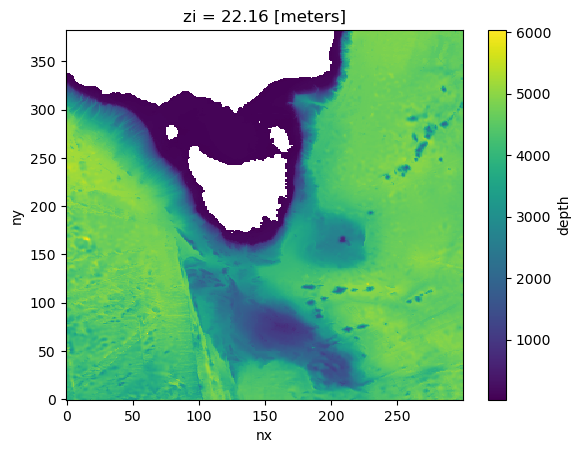

In [17]:
expt.topog.depth.plot()

##  Step 5: Handle the ocean forcing - where the magic happens

This cuts out and interpolates the initial condition as well as all boundaries (unless you don't pass it boundaries).

The dictionary maps the MOM6 variable names to what they're called in your ocean input file. Notice how the horizontal dimensions are x and y in the GLORYS reanalysis example, vs xh, yh, xq, yq. This is because ACCESS-OM2-01 is on a `B` grid, so we need to differentiate between `q` and `t` points. 

If one of your segments is land, you can delete its string from the 'boundaries' list. You'll need to update MOM_input to reflect this though so it knows how many segments to look for, and their orientations. 


In [ ]:
# Define a mapping from the MOM5 B grid variables and dimensions to the MOM6 C grid ones
ocean_varnames =     {"time":"time",
     "yh":"yt_ocean",
     "xh":"xt_ocean",
     "xq":"xu_ocean",
     "yq":"yu_ocean",
     "zl":"st_ocean",
     "eta":"eta_t",
     "u":"u",
     "v":"v",
     "tracers":{"salt":"salt","temp":"temp"}}

# Set up the initial condition
expt.initial_condition(
    tmpdir,     # The directory where the unprocessed initial condition is stored, as definied earlier
    ocean_varnames,
    gridtype="B"
    )

# Now iterate through our four boundaries 
for i,orientation in enumerate(["south","north","west","east"]):
    expt.setup_rectangular_boundary(
        tmpdir / (orientation + "_unprocessed.nc"),
        ocean_varnames,
        orientation,    # Needs to know the cardinal direction of the boundary
        i + 1,          # Just a number to identify the boundary. Indexes from 1 
        gridtype="B"
        )

## Step 6 Run the FRE tools

This is just a wrapper for the FRE tools needed to make the mosaics and masks for the experiment. The only thing you need to tell it is the processor layout. In this case we're saying that we want a 10 by 10 grid of 100 processors. 

In [ ]:
expt.FRE_tools((10,10))


## Step 7: Modify the default input directory to make a (hopefully) runnable configuration out of the box

This step copies the default directory, and modifies the `MOM_input` and `SIS_input` files to match your experiment. If you use Payu to run mom6, set the `using_payu` flag to `True` and an example `config.yaml` file will be copied to your run directory. This still needs to be modified manually to work with your projects, executable etc.



In [11]:
expt.setup_run_directory(surface_forcing = "jra",using_payu = True)

ln: failed to create symbolic link '/home/149/ab8992/mom6_rundirs/tasmania-september20-23//inputdir/tasmania-september20-23': File exists


## Step 8: Run your model!

To do this, navigate to your run directory in terminal. If you're working on NCI, you can do this via:

```
module load conda/analysis3
payu setup -f
payu run -f
```

By default `input.nml` is set to only run for 5 days as a test. If this is successful, you can modify this file to then run for longer.



## Step 9 and beyond: Fiddling, troubleshooting and fine tuning

Hopefully your model is running. If not, the first thing you should do is reduce the timestep. You can do this by adding `#override DT=XXXX` to your `MOM_override` file. 

If there's strange behaviour on your boundaries, you could play around with the `nudging timescale` (an example is already included in the `MOM_override` file). Sometimes, if your boundary has a lot going on (like all of the eddies spinning off the ACC), it can be hard to avoid these edge effects. This is because the chaotic, submesoscale structures developed within the regional domain won't match those at the boundary. 